In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from datetime import datetime
from datetime import timedelta
import matplotlib.cm as cm
import scipy

In [2]:
def calc_NSE(Qo, Qm):
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qo - Qm)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)
    
def calc_log_NSE(Qo, Qm):
    Qo[Qo == 0] = 1e-6
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((np.log(Qo) - np.log(Qm))**2)
    ErrDo = np.sum((np.log(Qo) - np.log(QoAv))**2)
    return 1 - (ErrUp / ErrDo)

In [3]:
units= {"Imax":"mm",
        "Ce": "-",
        "Sumax": "mm",
        "Beta": "-",
        "Pmax": "mm",
        "Tlag": "d",
        "Kf": "-",
        "Ks": "-",
        "FM":'mm/d/degC',
        "Si": "mm",
        "Su": "mm",
        "Sf": "mm",
        "Ss": "mm",
        "Sp": "mm",
        "Ei_dt": "mm/d",
        "Ea_dt": "mm/d",
        "Qs_dt": "mm/d",
        "Qf_dt": "mm/d",
        "Q_tot_dt": "mm/d",
        "Q": "mm/d"}

p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
names = p_names + S_names
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]

var_names =  {x: names[i] for i, x in enumerate(param_names + stor_names)}

In [4]:
def plot_hydrograph(ds_combined, ax, summary_stat):
    NSE_mean = calc_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat=summary_stat).values)
    NSE_mean_log = calc_log_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat=summary_stat).values)
    
    ds_combined["Q_obs"].plot(ax=ax,lw=0,marker="*",ms=2.0,zorder=0,label="Observations",color='k')
    
    ds_combined["Q"].sel(summary_stat=summary_stat).plot(ax=ax, color="C1",lw=0.5,label=f"NSE: {NSE_mean:.2f}\n   Log NSE: {NSE_mean_log:.2f}",zorder=-1)
    
    ax.fill_between(ds_combined.time, 
                             ds_combined["Q"].sel(summary_stat="min").values,
                             ds_combined["Q"].sel(summary_stat="max").values,color="C0", alpha=0.35,zorder=-10,label="bounds")
    n_particles = ds_combined.attrs['n_particles']
    ax.set_ylabel("Q [mm]")
    ax.set_title(f"Data assimilation experiment with {n_particles} particles");
    return ax

In [5]:
def plot_variable(ds_combined, variable, axs):    
    axs[0] = plot_hydrograph(ds_combined, axs[0])
    n_particles = ds_combined.attrs['n_particles']
    
    for i, var in enumerate(variable):
        axs[i+1].fill_between(ds_combined.time, 
                         ds_combined[var].sel(summary_stat="min").values,
                         ds_combined[var].sel(summary_stat="max").values, color=f"C{i}",alpha=0.5)
        axs[i+1].set_title(var_names[var])
        axs[i+1].set_ylabel(f'{var} [{units[var]}]')
    return axs

In [6]:
path = Path.cwd() 
figure_path = path / "Figures"

### DA best ensemble member

In [7]:
best_ds_files = list((path.parent.parent.parent / "run_experiment_best" / 'Output').glob("*.nc"))

In [8]:
best_ds_lst = []
for file in best_ds_files:
    best_ds_lst.append(xr.open_dataset(file))

In [9]:
df_best = pd.DataFrame(columns=["NSE_mean_DA","log_NSE_mean_DA","NSE_best_DA","log_NSE_best_DA","path_DA"],)
for index, ds in enumerate(best_ds_lst):
    uid = ds.attrs['HRU_id']
    df_best.loc[uid, 'NSE_mean_DA'] = calc_NSE(ds["Q_obs"].values, ds["Q"].sel(summary_stat="mean").values)
    df_best.loc[uid, 'log_NSE_mean_DA'] = calc_log_NSE(ds["Q_obs"].values, ds["Q"].sel(summary_stat="mean").values)
    df_best.loc[uid, 'NSE_best_DA'] = calc_NSE(ds["Q_obs"].values, ds["Q"].sel(summary_stat="best").values)
    df_best.loc[uid, 'log_NSE_best_DA'] = calc_log_NSE(ds["Q_obs"].values, ds["Q"].sel(summary_stat="best").values)
    df_best.loc[uid,'path_DA'] = best_ds_files[index]

In [10]:
df_best.head(3)

NSE_mean_DA log_NSE_mean_DA NSE_best_DA log_NSE_best_DA  \
01013500     0.57813        -0.55511    0.861828        0.662818   
01022500    0.521113        0.541622    0.655206        0.706836   
01030500     0.15002        0.319357    0.412902        0.476651   

                                                    path_DA  
01013500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  
01022500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  
01030500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...

In [11]:
len(df_best)

670

### calibration

In [15]:
callibration_ds_files = list((path.parent.parent.parent / "run_callibration" / 'Output').glob("*.nc"))

In [16]:
cal_ds_lst = []
for file in callibration_ds_files:
    cal_ds_lst.append(xr.open_dataset(file))

In [17]:
cal_ds_lst[0]

<xarray.Dataset>
Dimensions:         (EnsembleMember: 2, time: 1857)
Coordinates:
  * EnsembleMember  (EnsembleMember) int64 308 443
  * time            (time) datetime64[ns] 1997-08-01 1997-08-02 ... 2002-08-31
Data variables: (12/16)
    Imax            (EnsembleMember, time) float64 ...
    Ce              (EnsembleMember, time) float64 ...
    Sumax           (EnsembleMember, time) float64 ...
    Beta            (EnsembleMember, time) float64 ...
    Pmax            (EnsembleMember, time) float64 ...
    Tlag            (EnsembleMember, time) float64 ...
    ...              ...
    Su              (EnsembleMember, time) float64 ...
    Sf              (EnsembleMember, time) float64 ...
    Ss              (EnsembleMember, time) float64 ...
    Sp              (EnsembleMember, time) float64 ...
    Q               (EnsembleMember, time) float64 ...
    Q_obs           (time) float64 ...
Attributes:
    title:          HBV storage & parameter terms data over time for 500 part...
    history:        Storage term results from ewatercycle_HBV.model
    n_particles:    500
    HRU_id:         01013500
    NSE_max:        0.8000585706940022
    log_NSE_max:    0.7713077092046793
    i_NSE_max:      308
    i_log_NSE_max:  443

In [18]:
df_cal = pd.DataFrame(columns=["NSE_cal","log_NSE_cal","path_cal"],)
for index, ds in enumerate(cal_ds_lst):
    uid = ds.attrs['HRU_id']
    df_cal.loc[uid, 'NSE_cal'] = ds.attrs['NSE_max']
    df_cal.loc[uid, 'log_NSE_cal'] = ds.attrs['log_NSE_max']
    df_cal.loc[uid,'path_cal'] = callibration_ds_files[index]

In [19]:
df_cal.head(3)

NSE_cal log_NSE_cal  \
01013500  0.800059    0.771308   
01022500  0.640479    0.790192   
01030500  0.437132    0.631559   

                                                   path_cal  
01013500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  
01022500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  
01030500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...

In [20]:
len(df_cal)

670

In [21]:
indexes = list(set(df_cal.index).intersection(df_best.index))

In [22]:
df_cal_common = df_cal.loc[indexes]
df_best_common = df_best.loc[indexes]

In [23]:
df = pd.concat([df_cal_common,df_best_common],axis=1)

In [24]:
df.columns

Index(['NSE_cal', 'log_NSE_cal', 'path_cal', 'NSE_mean_DA', 'log_NSE_mean_DA',
       'NSE_best_DA', 'log_NSE_best_DA', 'path_DA'],
      dtype='object')

In [25]:
df[['NSE_cal', 'log_NSE_cal', 'NSE_mean_DA', 'log_NSE_mean_DA',
       'NSE_best_DA', 'log_NSE_best_DA']].to_feather('DA_vs_calibrated.feather')

In [26]:
len_df_all = len(df)

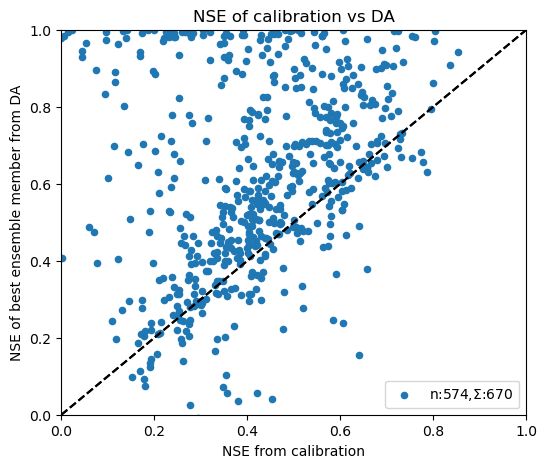

In [27]:
# fig, axs = plt.subplots(1,2,figsize=(12,5))
# ax = axs[0]

fig, ax = plt.subplots(1,1,figsize=(6,5))

label = f"n:{len(df[(df['NSE_cal'] > 0 ) & (df['NSE_best_DA'] > 0 )])},$\Sigma$:{len_df_all}"
df.plot.scatter('NSE_cal','NSE_best_DA',ax=ax,color="C0",label=label)
ax.set_xlabel("NSE from calibration")
ax.set_ylabel("NSE of best ensemble member from DA")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot([[0,0],[1,1]],color="k",ls="--")
ax.set_title('NSE of calibration vs DA')
ax.legend(loc='lower right')

# ax = axs[1]
# label = f"n:{len(df[(df['log_NSE_cal'] > 0 ) & (df['log_NSE_best_DA'] > 0 )])},$\Sigma$:{len_df_all}"
# df.plot.scatter('log_NSE_cal','log_NSE_best_DA',ax=ax,color="C1",label=label)
# ax.set_xlabel("log(NSE) from calibration")
# ax.set_ylabel("log(NSE) of best ensemble member from DA")
# ax.set_title('log(NSE) of calibration vs DA')
# ax.set_xlim(0,1)
# ax.set_ylim(0,1)
# ax.plot([[0,0],[1,1]],color="k",ls="--");
# ax.legend(loc='lower right')

fig.savefig(figure_path / 'NSE_comparison_best.png',bbox_inches='tight',dpi=150)

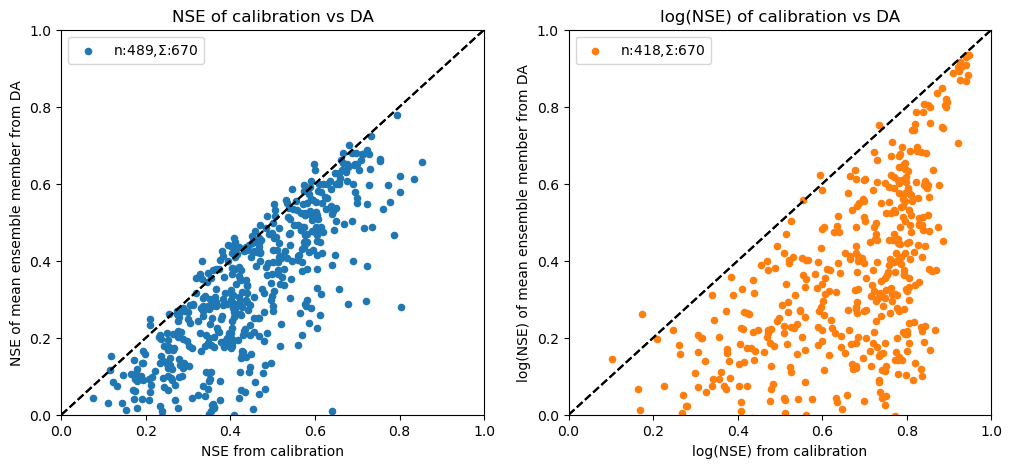

In [28]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
ax = axs[0]
label = f"n:{len(df[(df['NSE_cal'] > 0 ) & (df['NSE_mean_DA'] > 0 )])},$\Sigma$:{len_df_all}"
df.plot.scatter('NSE_cal','NSE_mean_DA',ax=ax,color="C0",label=label)
ax.set_xlabel("NSE from calibration")
ax.set_ylabel("NSE of mean ensemble member from DA")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot([[0,0],[1,1]],color="k",ls="--")
ax.legend()
ax.set_title('NSE of calibration vs DA')

ax = axs[1]
label = f"n:{len(df[(df['log_NSE_cal'] > 0 ) & (df['log_NSE_mean_DA'] > 0 )])},$\Sigma$:{len_df_all}"
df.plot.scatter('log_NSE_cal','log_NSE_mean_DA',ax=ax,color="C1",label=label)
ax.set_xlabel("log(NSE) from calibration")
ax.set_ylabel("log(NSE) of mean ensemble member from DA")
ax.set_title('log(NSE) of calibration vs DA')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot([[0,0],[1,1]],color="k",ls="--");

fig.savefig(figure_path / 'NSE_comparison.png',bbox_inches='tight',dpi=150)

Text(0.5, 1.0, 'NSE of calibration vs DA')

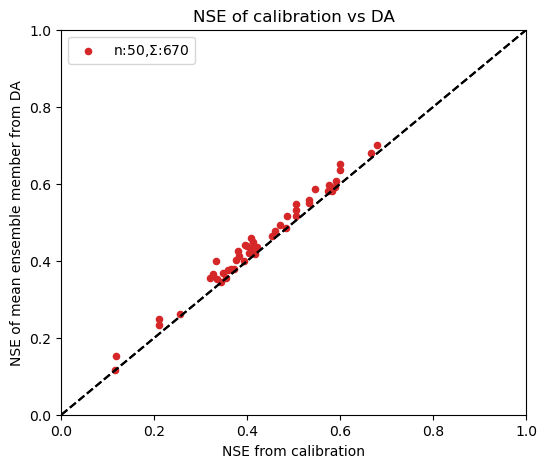

In [29]:
fig, ax = plt.subplots(1,1,figsize=(6,5))

df_better = df[(df['NSE_cal']  < df['NSE_mean_DA'])]
label = f"n:{len(df_better)},$\Sigma$:{len(df)}"
df_better.plot.scatter('NSE_cal','NSE_mean_DA',ax=ax,color="C3",label=label)
ax.set_xlabel("NSE from calibration")
ax.set_ylabel("NSE of mean ensemble member from DA")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot([[0,0],[1,1]],color="k",ls="--")
ax.legend()
ax.set_title('NSE of calibration vs DA')

In [30]:
(df_better['NSE_mean_DA'] - df_better['NSE_cal']).sort_values()

04213000     0.000035
03300400     0.000102
14236200     0.000474
14096850     0.000497
01552000     0.000726
03574500     0.001162
12020000     0.002471
05495500     0.004965
01567500     0.005008
02300700     0.005841
01142500     0.006797
01669000     0.010735
01532000      0.01246
04233000     0.012842
12025000     0.014516
14138800     0.015109
03069500     0.015998
12178100     0.016228
14308990      0.01623
01415000     0.016904
03015500     0.017506
01620500     0.018663
05591550     0.019615
12013500     0.020596
12010000     0.022797
05399500     0.022949
03456500     0.023169
03026500     0.023761
01542810     0.026153
14182500     0.027357
01413500     0.027908
01047000      0.02932
02051500     0.031385
12189500      0.03487
04043050     0.035241
07167500      0.03612
02327100     0.036349
03066000     0.037851
08164000     0.038604
03186500     0.039507
03028000     0.041965
01031500     0.042297
01365000      0.04669
01414500     0.047061
03078000     0.052328
12043000  

# analyse

In [31]:
df.sort_values("NSE_best_DA",ascending=False).head(40)

NSE_cal log_NSE_cal  \
06360500  0.199864    0.338559   
09306242  0.496663    0.072683   
06354000  0.186127    0.322767   
06447500  0.134243    0.121479   
09512280  0.175658    0.206804   
09447800  0.023074    0.042727   
06350000  0.140964    0.132625   
07301500  0.389571    0.338664   
06468170  0.304892    0.280695   
05057000   0.48085    0.558339   
09497980  0.605546    0.770799   
07142300  0.495861    0.229423   
08150800  0.508161    0.275774   
05057200  0.228871    0.114812   
06447000  0.132223    0.269753   
10329500  0.715911     0.80693   
13161500  0.802539    0.839211   
09312600  0.723371    0.409963   
07149000  0.491556     0.42035   
06406000 -0.351449    0.037707   
06353000  0.013759    0.113611   
07299670 -0.020515    0.036119   
10166430  0.265089    0.098151   
06344600  0.225905    0.436248   
07148400   0.54283    0.518652   
09484600  0.096085    0.421622   
10258500   0.31955    0.407856   
05120500  0.258602     0.27151   
09430500  0.173601    0.632283   
08104900  0.514258    0.588758   
09404450  0.283577    0.231607   
08103900  0.241272    0.267372   
08196000  0.354752    0.371836   
05056000  0.563888    0.679302   
06453600  0.449979    0.315338   
06404000  0.464769      0.3391   
08380500  0.457841    0.503966   
06452000  0.275676    0.600225   
08079600 -0.087964   -0.050017   
04122200  0.303964   -0.163494   

                                                   path_cal NSE_mean_DA  \
06360500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...   -4.364298   
09306242  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...    -1.74634   
06354000  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...   -4.898506   
06447500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...   -2.291322   
09512280  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  -24.881652   
09447800  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...   -3.295709   
06350000  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...    -9.86398   
07301500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...   -2.679285   
06468170  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...   -3.190979   
05057000  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...    0.065981   
09497980  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...    0.328464   
07142300  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  -15.278129   
08150800  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...   -8.183304   
05057200  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...   -4.344856   
06447000  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...   -7.366093   
10329500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...    0.485375   
13161500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...    0.280971   
09312600  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...     0.38529   
07149000  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...   -0.033102   
06406000  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  -60.550502   
06353000  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  -47.984709   
07299670  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...   -7.503639   
10166430  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...   -1.225036   
06344600  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...   -1.832792   
07148400  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...   -0.043048   
09484600  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  -20.894715   
10258500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...    0.315106   
05120500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...   -1.819387   
09430500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...    0.061558   
08104900  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...   -0.075801   
09404450  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...   -0.812209   
08103900  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...   -3.993987   
08196000  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...   -0.319984   
05056000  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...    0.2

In [32]:
df.sort_values("NSE_cal",ascending=True).head(7)

NSE_cal log_NSE_cal  \
08202700 -426.533033   -0.576333   
08190500 -246.604686   -0.597168   
08198500 -113.282866   -0.413035   
06775500 -109.426044 -972.276773   
06477500  -93.146547   -0.755993   
07226500  -65.435007    -0.69666   
08086212  -57.893484   -0.097605   

                                                   path_cal  NSE_mean_DA  \
08202700  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r... -3614.522695   
08190500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r... -2999.672845   
08198500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  -609.202866   
06775500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  -126.598768   
06477500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  -2705.46932   
07226500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r... -8024.494895   
08086212  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r... -2279.945406   

         log_NSE_mean_DA NSE_best_DA log_NSE_best_DA  \
08202700       -1.953617 -126.702942       -0.304054   
08190500       -2.691948  -19.981628        0.371842   
08198500       -1.723174  -19.886466          0.1677   
06775500    -2696.225404 -121.986116    -1838.567807   
06477500       -2.627223   -8.770341        0.166682   
07226500       -2.753173   -2.578204       -0.204003   
08086212       -1.072516   -7.283366        0.386937   

                                                    path_DA  
08202700  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  
08190500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  
08198500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  
06775500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  
06477500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  
07226500  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...  
08086212  D:\work\Studie TUD\Msc\Year 6\Q3 Thesis\Code\r...

In [33]:
def generate_plots(df, catchment):
    fig, axs = plt.subplots(2,1, figsize=(12,5),sharex=True, sharey=True)
    
    ds_lst = []
    ax = axs[0]
    ds = xr.open_dataset(df.loc[catchment]['path_DA'])
    ds_lst.append(ds)
    ax = plot_hydrograph(ds, ax, 'best')
    ax.legend(title=ds.attrs['HRU_id'],bbox_to_anchor=(1,1))
    
    ax = axs[1]
    ds = xr.open_dataset(df.loc[catchment]['path_cal'])
    ds_lst.append(ds)
    if ds.EnsembleMember.size == 2 :
        if len(set(ds.EnsembleMember.to_numpy())) == 1:
            ax.plot(ds["Q"].time.values, ds["Q"].sel(EnsembleMember=ds.attrs['i_NSE_max']).values[0],color="C3", zorder=10,label=f"NSE:{ds.attrs['NSE_max']:.2f}")    
        else:
            ax.plot(ds["Q"].time.values, ds["Q"].sel(EnsembleMember=ds.attrs['i_NSE_max']).values,color="C3", zorder=10,label=f"NSE:{ds.attrs['NSE_max']:.2f}")    
            ax.plot(ds["Q"].time.values, ds["Q"].sel(EnsembleMember=ds.attrs['i_log_NSE_max']).values,color="C0",label=f"logNSE:{ds.attrs['log_NSE_max']:.2f}")
    else:
        ax.plot(ds["Q"].time.values, ds["Q"].values,color="C3", zorder=10,label=f"NSE:{ds.attrs['NSE_max']:.2f}")  


    ds["Q_obs"].plot(ax=ax,color='k',lw=0,marker='.')
    ax.legend(title=ds.attrs['HRU_id'],bbox_to_anchor=(1,1))
    ax.set_title('Callibrated HBV model using 500 Monte Carlo simulations')
    
    fig.tight_layout()
    return fig, ds_lst

In [34]:
def plot_residuals(ds_lst, diff=False):
    ds0 = ds_lst[0]
    ds1 = ds_lst[1]
    ds0_NSE = ds0.sel(summary_stat='best')
    ds0_NSE['Q_res'] = ('time', (ds0_NSE['Q_obs'].to_numpy() -  ds0_NSE['Q'].to_numpy()))

    if ds1.EnsembleMember.size == 1:
        ds1_NSE = ds1
        
    elif ds1.EnsembleMember.size == 2 :
        if len(set(ds1.EnsembleMember.to_numpy())) == 1:
            ds1_NSE = ds1.isel(EnsembleMember=0)
        else:
            ds1_NSE = ds1.sel(EnsembleMember=ds1.attrs['i_NSE_max'])
            
    ds1_NSE['Q_res'] = ('time', (ds1_NSE['Q_obs'].to_numpy() -  ds1_NSE['Q'].to_numpy()))

    if diff: 
        n = 2
        fig, axs = plt.subplots(n,1, figsize=(10,5),sharex=True,sharey=True)
        ax = axs[0]
    else: 
        n = 1
        fig, ax = plt.subplots(n,1, figsize=(10,2.5),sharex=True,sharey=True)
    
    common_kwargs = {'lw':0, 'marker':"."}
    
    
    ds0_NSE['Q_res'].plot(ax=ax,**common_kwargs,label=f"Data assimilated:∑={np.sum(ds0_NSE['Q_res'].to_numpy()**2):.2f}",color='C1')
    ax.axhline(0,color='k')
    ax.set_xlabel(None)

    ds1_NSE['Q_res'].plot(ax=ax,**common_kwargs,label=f"Callibrated:∑={np.sum(ds1_NSE['Q_res'].to_numpy()**2):.2f}",color='C2',zorder=-1)
    ax.legend()
    ax.set_title('Residual for DA & Callibrated ')
    ax.set_ylabel('Residuals: Obs - M')

    if diff: 
        ax = axs[1]
        (ds1_NSE['Q_res'] - ds0_NSE['Q_res']).plot(ax=ax,**common_kwargs,color='C4')
        ax.axhline(0,color='k')
        ax.set_title('Difference: DA - Callibrated ')
        ax.set_ylabel('squared Residuals')
    
    
    fig.tight_layout()
    return fig, [ds0, ds1_NSE]

In [116]:
def plot_params(names, ds_lst, ax):
    min_max_kwargs = dict(color=f"grey",lw=0.5,ls='--')
    for i, param in enumerate(names): 
        if param is None:
            ax[i].axis('off');
        else:
            ds_lst[0][param].sel(summary_stat='min').plot(ax=ax[i],label='min/max', **min_max_kwargs)
            ds_lst[0][param].sel(summary_stat='max').plot(ax=ax[i],**min_max_kwargs)
            if i == 8:
                color = f"C{i+1}"
            else:
                color = f"C{i}"
            ds_lst[0][param].sel(summary_stat='best').plot(ax=ax[i],color=color,lw=0.1,label='Best DA',marker=".",ms=0.5)
            ds_lst[0][param].sel(summary_stat='mean').plot(ax=ax[i],color=color,lw=1.5,label='mean DA')
            

            if i == 10:
                lw=0.4
            else:
                lw=0.8
            ds_lst[1][param].plot(ax=ax[i],color='k',label='Calibrated',alpha=0.8,lw=lw)
            ax[i].set_title(param)
            if i in [8]:
                ax[i].set_ylabel('Number of catchments')
                ax[i].legend(bbox_to_anchor=(1,1))


In [117]:
def plot_params_slope(ds_combined, params, ax, regress=False):
    for j, parameter in enumerate(params):
        ax = axs[j]
        n_particles = ds_combined.attrs['n_particles']
        ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="k", label="mean")
        ax.fill_between(ds_combined.time, 
                         ds_combined[parameter].sel(summary_stat="min").values,
                         ds_combined[parameter].sel(summary_stat="max").values,alpha=0.75, color=f"C{j}")
        ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
        ax.set_ylabel(f'[{units[param_names[j]]}]')
        if j == 0: 
            ax.legend()

        if regress:
            x = range(len(ds_combined.time))
            result = scipy.stats.linregress(x, ds_combined[parameter].sel(summary_stat='mean').to_numpy())
            y = result.slope * x + result.intercept
            ax.plot(ds_combined.time, y, color="w",label=f"R$^2$={result.rvalue**2:.2f}")
            slope_text = '$m_{std}=$'
            ax.legend(title=f'{slope_text}{result.slope*365/y.mean():.4f}')

## Chose one: 

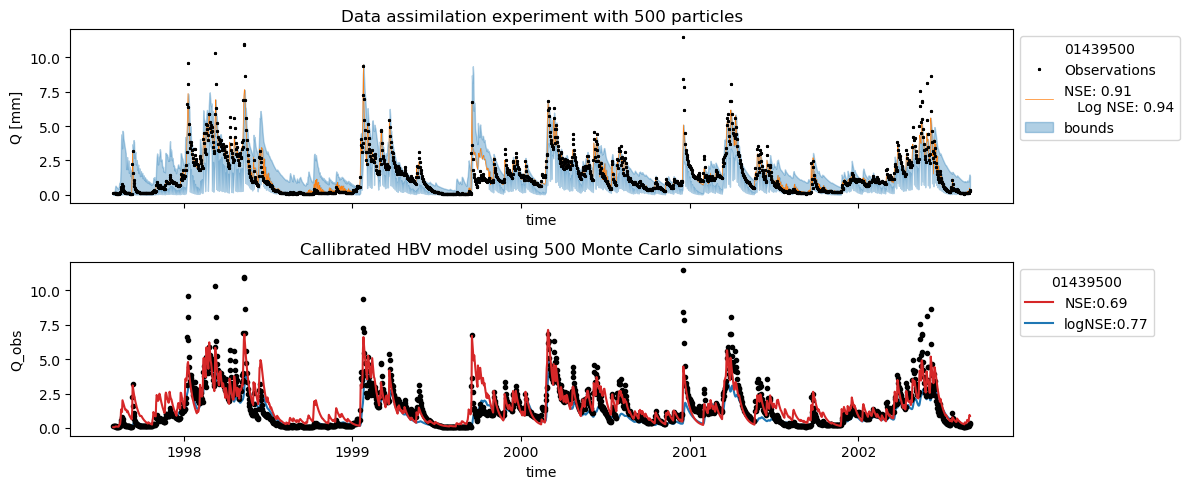

In [118]:
fig, ds_lst = generate_plots(df, '01439500')
# fig.savefig(figure_path / f"data_assimilated_vs_callibrated value for {ds_lst[0].attrs['HRU_id']}.png",bbox_inches="tight", dpi=150)

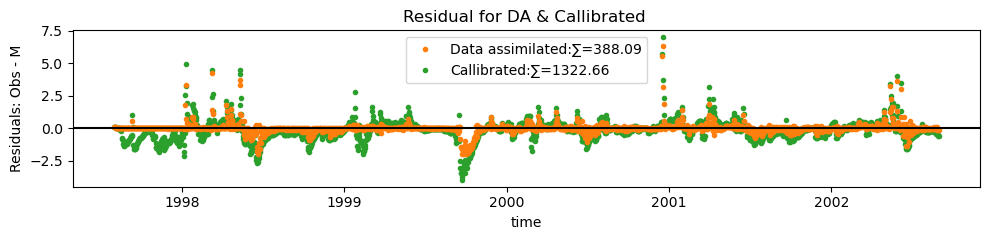

In [119]:
fig2, ds_lst = plot_residuals(ds_lst,diff=False)

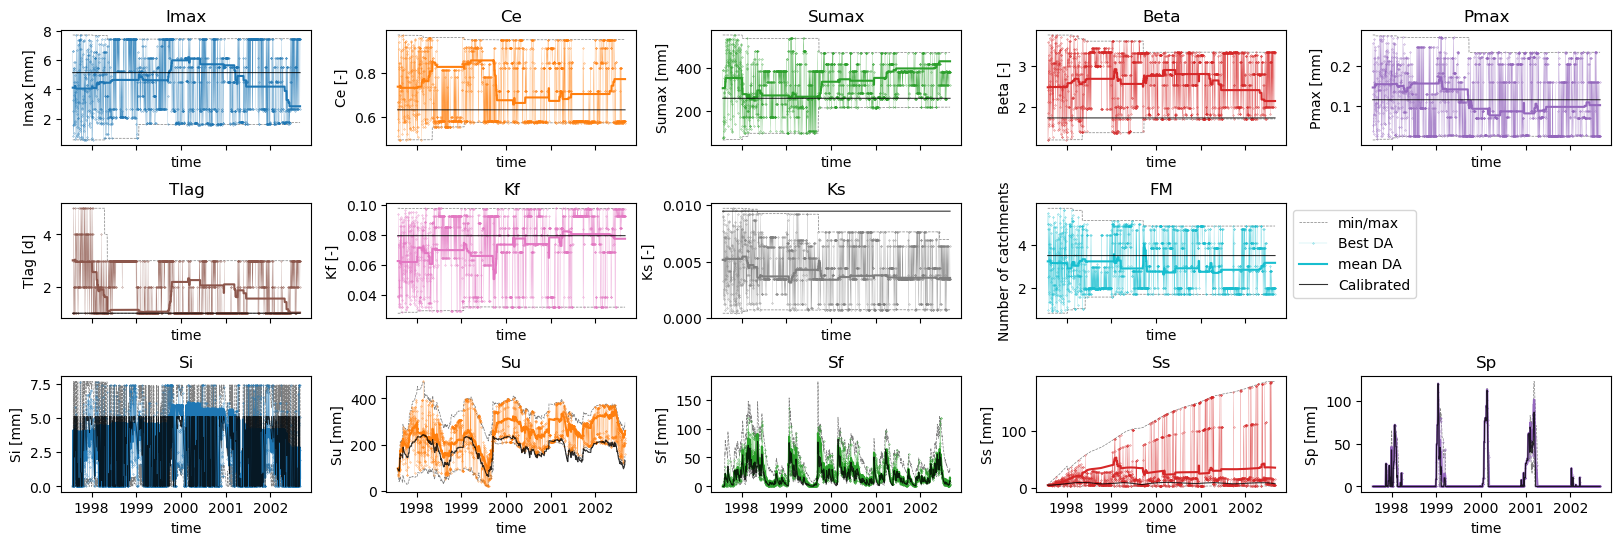

In [120]:
fig, ax = plt.subplots(3,5, figsize=(20,6),sharex=True)
ax = ax.flatten()
names = param_names + [None] + stor_names
plot_params(names, ds_lst, ax )
fig.subplots_adjust(hspace=0.5, wspace=0.3)
# fig.savefig(figure_path / f"data_assimilated_vs_callibrated_prameter_states_for_{ds_lst[0].attrs['HRU_id']}.png",bbox_inches="tight", dpi=150)

## more:

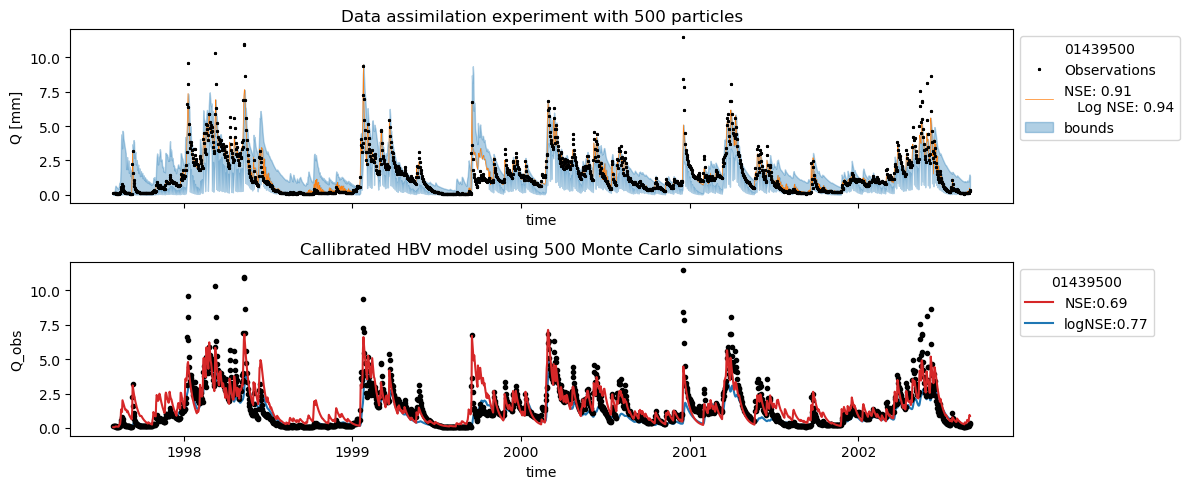

In [40]:
fig, ds_lst = generate_plots(df, '01439500')

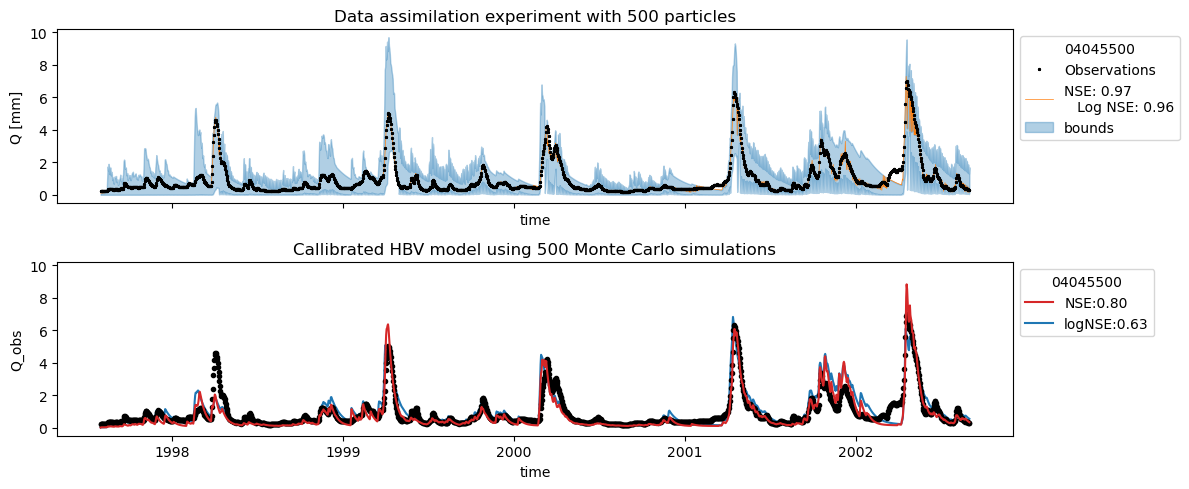

In [41]:
fig, ds_lst = generate_plots(df, '04045500')

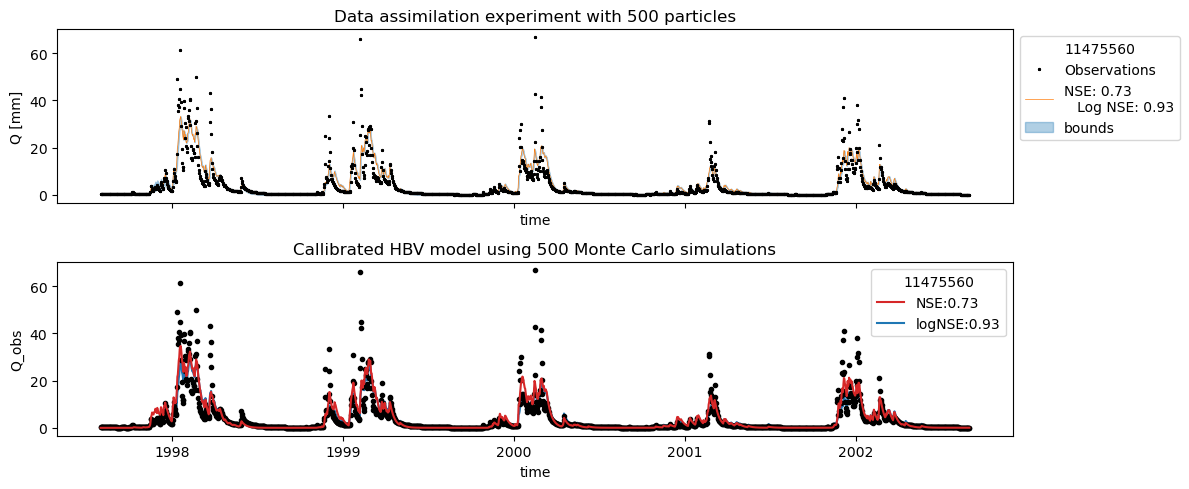

In [42]:
fig, ds_lst = generate_plots(df, '11475560')

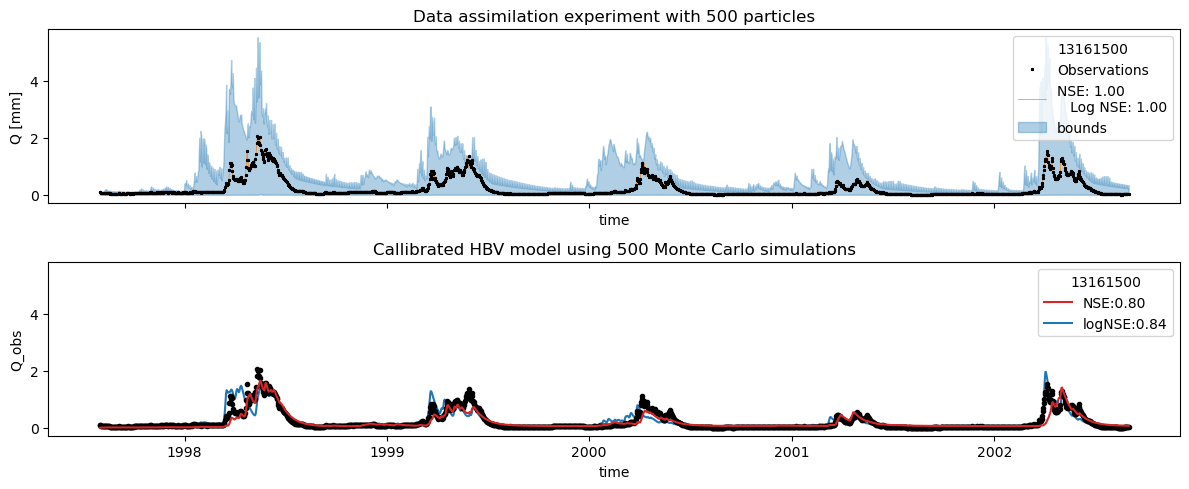

In [43]:
fig, ds_lst = generate_plots(df, '13161500')

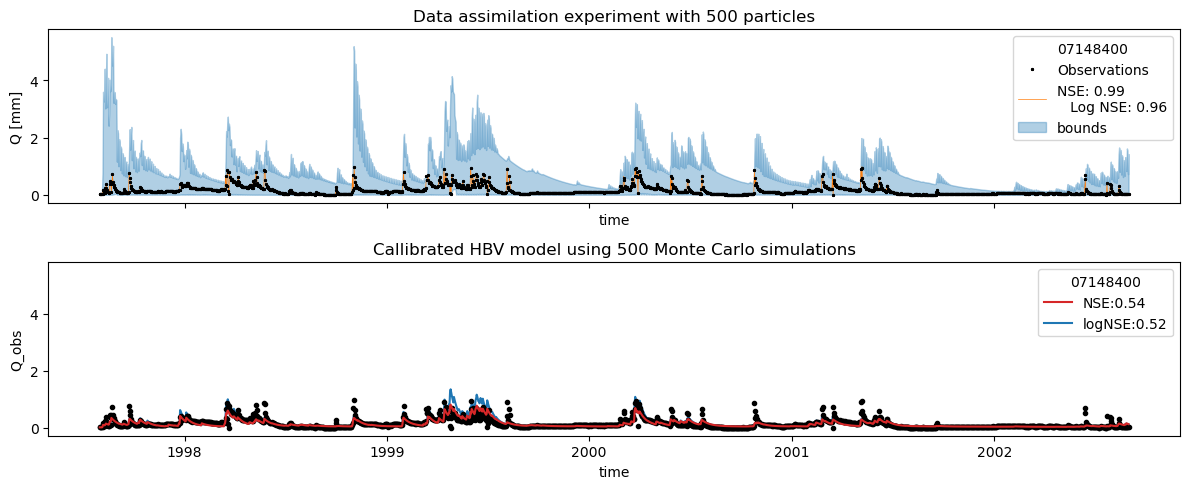

In [44]:
fig, ds_lst = generate_plots(df, '07148400')

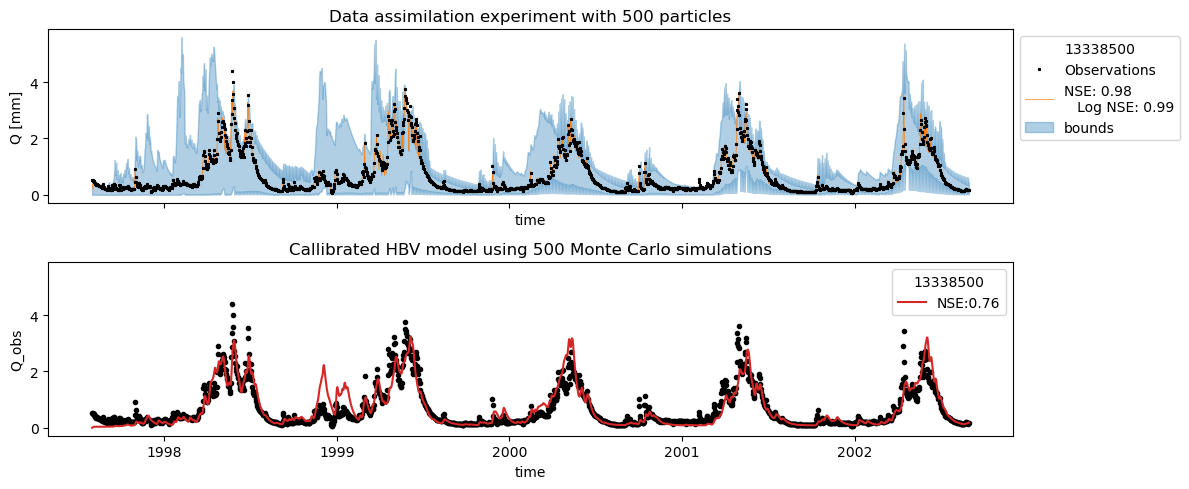

In [45]:
fig, ds_lst = generate_plots(df, '13338500')
# fig.savefig(figure_path / f"Ensemble run vs callibrated value for {ds.attrs['HRU_id']}.png",bbox_inches="tight", dpi=150)

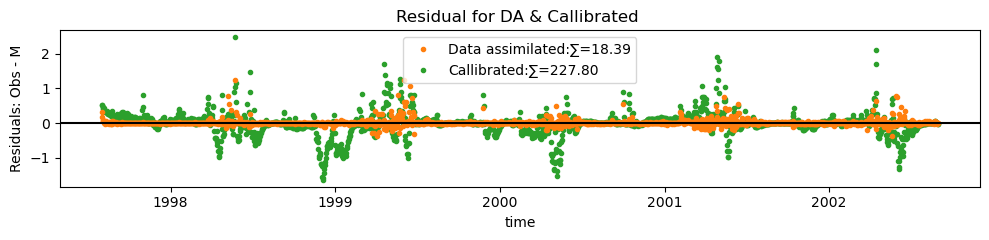

In [46]:
fig = plot_residuals(ds_lst)

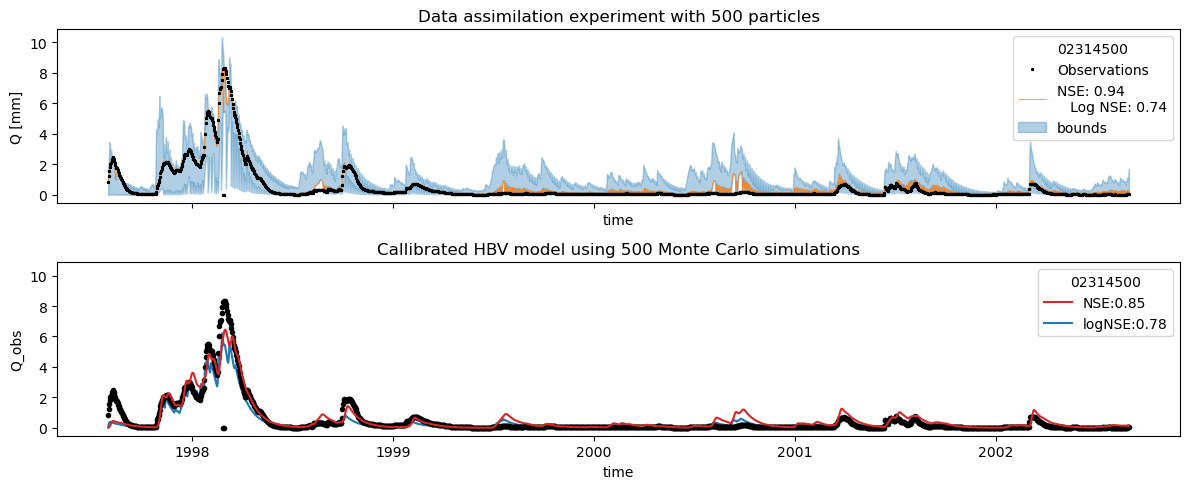

In [47]:
fig, ds_lst= generate_plots(df, '02314500')
# fig.savefig(figure_path / f"Ensemble run vs callibrated value for {ds.attrs['HRU_id']}.png",bbox_inches="tight", dpi=150)

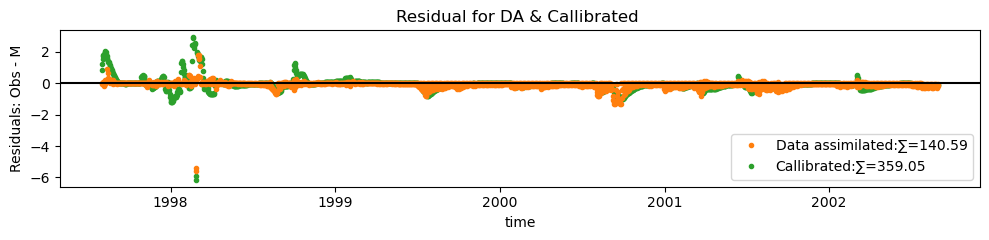

In [48]:
fig = plot_residuals(ds_lst)

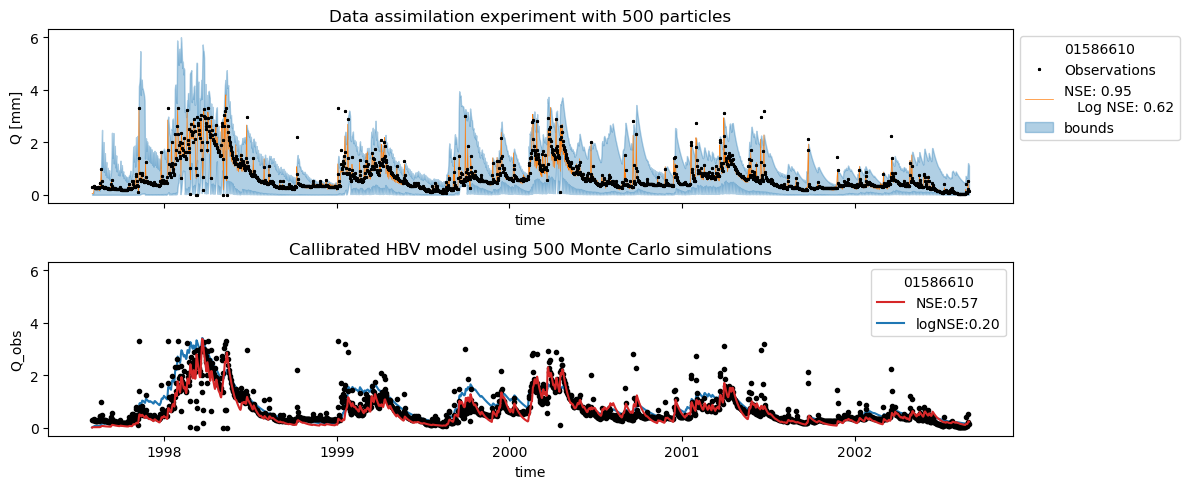

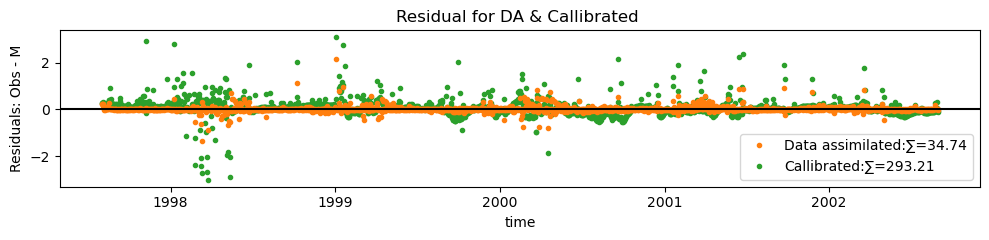

In [49]:
fig, ds_lst = generate_plots(df, '01586610')
# fig.savefig(figure_path / f"Ensemble run vs callibrated value for {ds.attrs['HRU_id']}.png",bbox_inches="tight", dpi=150)
fig, ds_lst = plot_residuals(ds_lst)

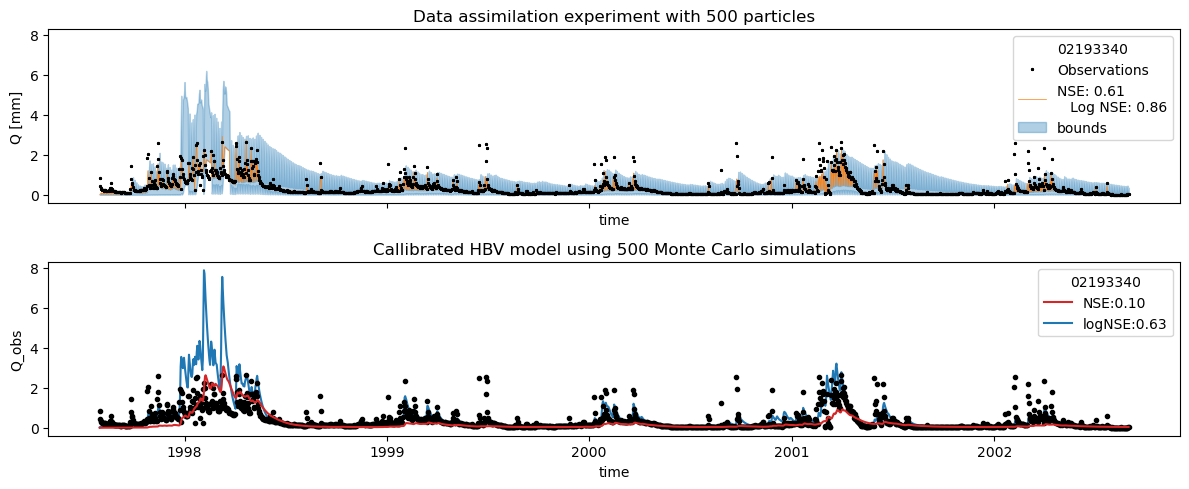

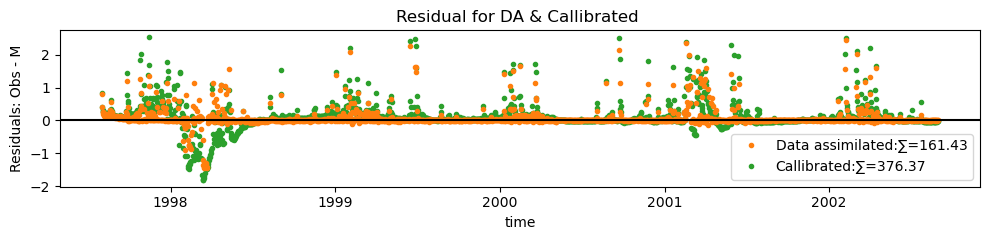

In [50]:
fig, ds_lst = generate_plots(df, '02193340')
# fig.savefig(figure_path / f"Ensemble run vs callibrated value for {ds.attrs['HRU_id']}.png",bbox_inches="tight", dpi=150)
fig2 = plot_residuals(ds_lst)

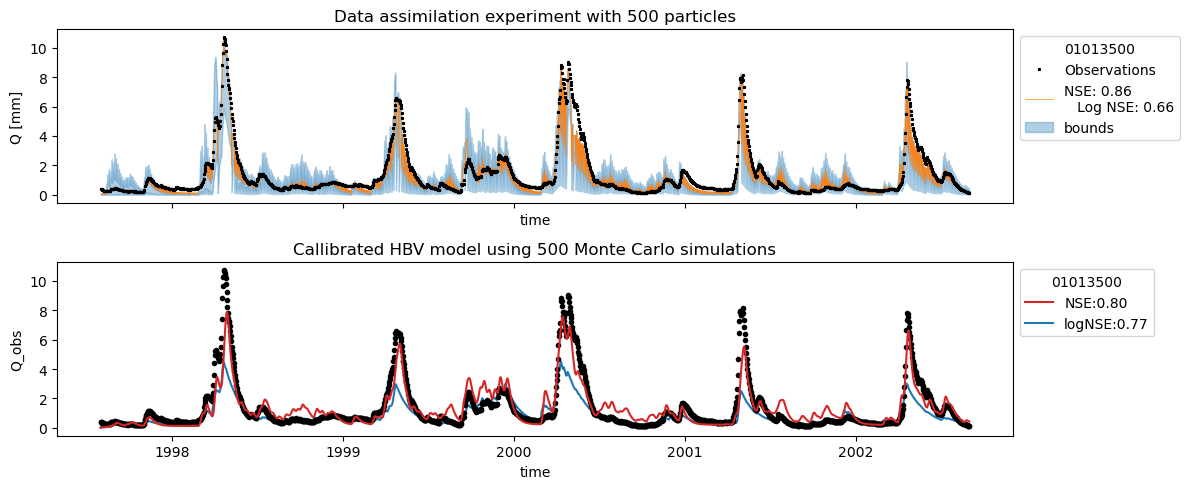

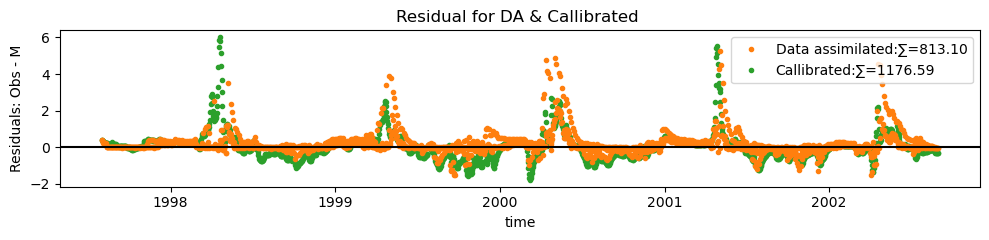

In [51]:
fig, ds_lst = generate_plots(df, '01013500')
# fig.savefig(figure_path / f"Ensemble run vs callibrated value for {ds.attrs['HRU_id']}.png",bbox_inches="tight", dpi=150)
fig2 = plot_residuals(ds_lst)
# fig2.savefig(figure_path / f"Residuals for DA run vs callibrated value for {ds_lst[0].attrs['HRU_id']}.png",bbox_inches="tight", dpi=150)

## 01073000

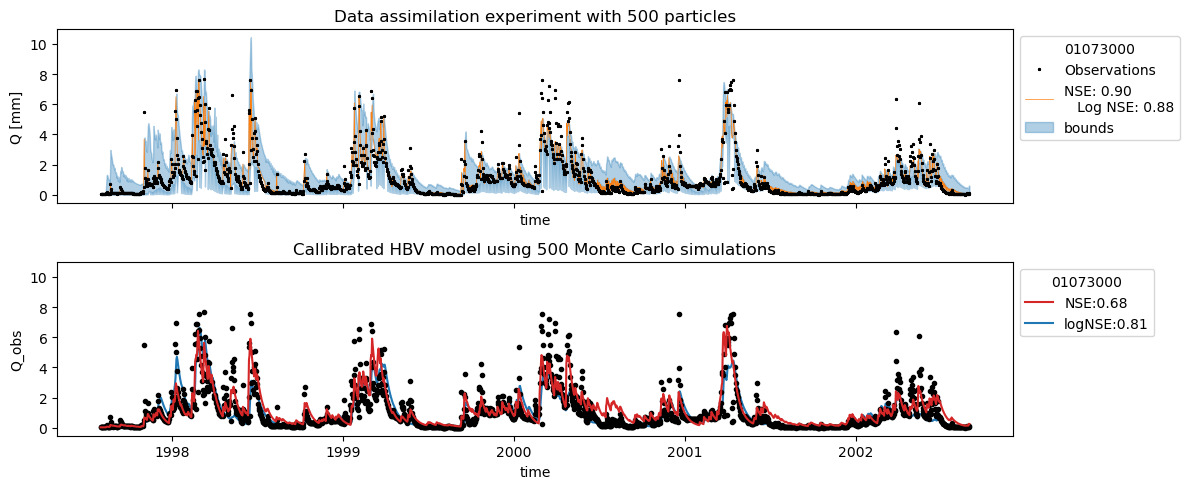

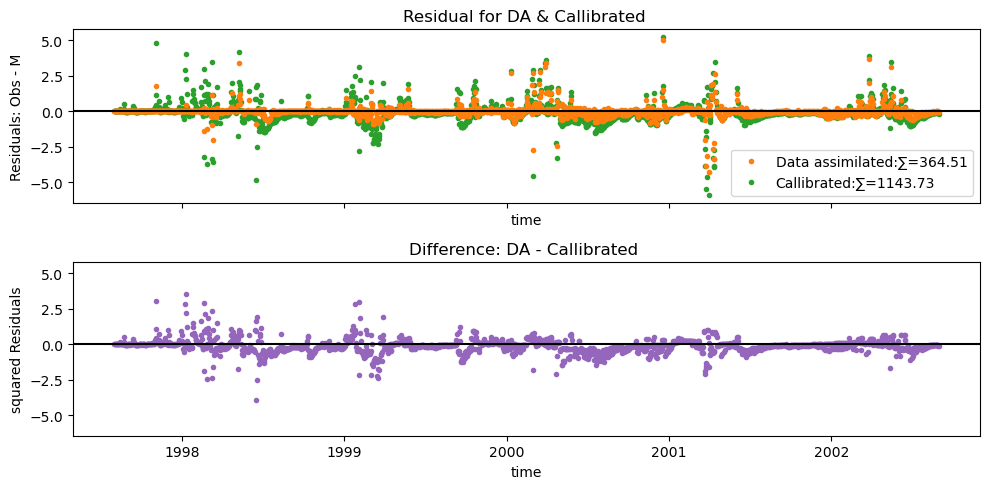

In [52]:
fig, ds_lst= generate_plots(df, '01073000')
# fig.savefig(figure_path / f"Ensemble run vs callibrated value for {ds.attrs['HRU_id']}.png",bbox_inches="tight", dpi=150)
fig2, ds_lst = plot_residuals(ds_lst,diff=True)
# fig2.savefig(figure_path / f"Residuals for DA run vs callibrated value for {ds_lst[0].attrs['HRU_id']}.png",bbox_inches="tight", dpi=150)

### investigate a post - flood 

In [53]:
ds0, ds1 = ds_lst
t_index = (ds0.time > np.datetime64('2000-01-01')) & (ds0.time < np.datetime64('2000-09-01')).values
ds_lst = [ds0.sel(time=t_index), ds1.sel(time=t_index)]

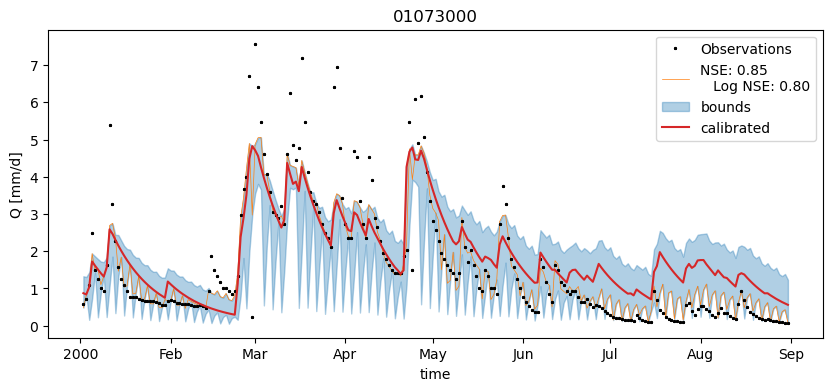

In [54]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
plot_hydrograph(ds_lst[0], ax, summary_stat='best')
ds_lst[1]['Q'].plot(ax=ax,color='C3',label='calibrated')
ax.legend()
ax.set_title(f'{ds_lst[0].attrs["HRU_id"]}');

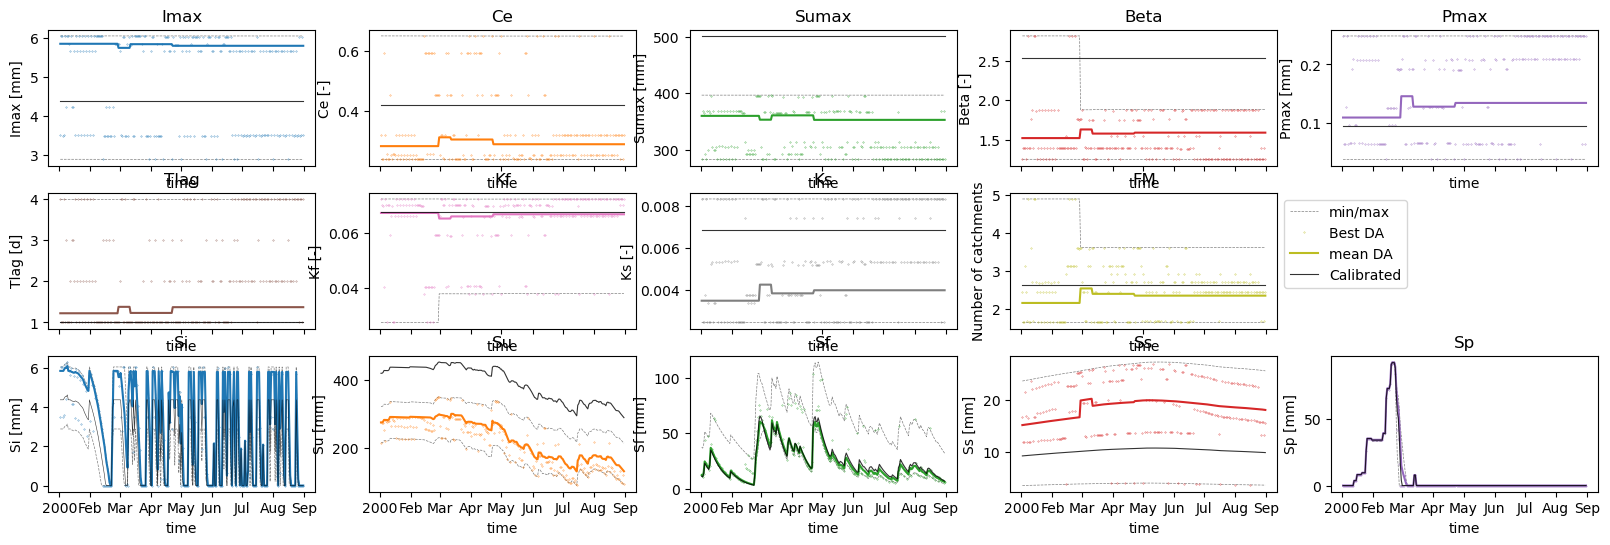

In [55]:
fig, ax = plt.subplots(3,5, figsize=(20,6),sharex=True)
ax = ax.flatten()
names = param_names + [None] + stor_names
plot_params(names, ds_lst, ax )

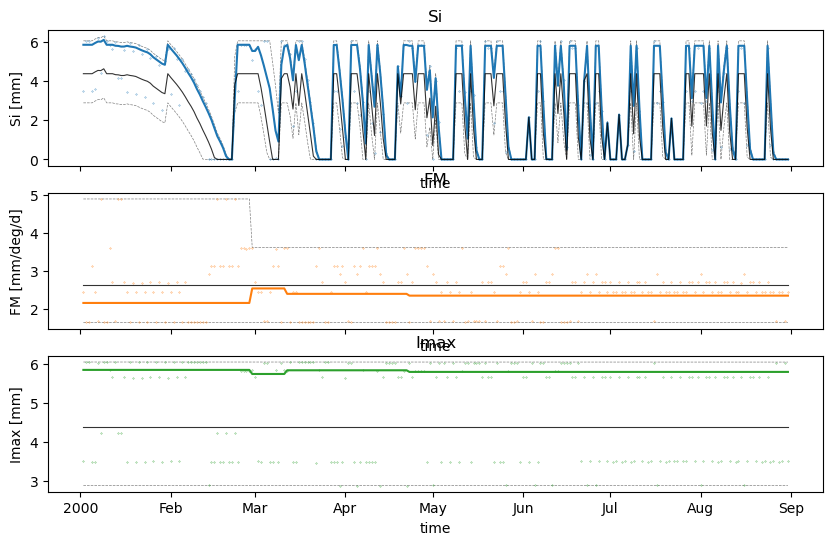

In [56]:
names = ['Si','FM','Imax']
n = len(names)
fig, ax = plt.subplots(n,1, figsize=(10,n*2),sharex=True)
ax = ax.flatten()
plot_params(names, ds_lst, ax)

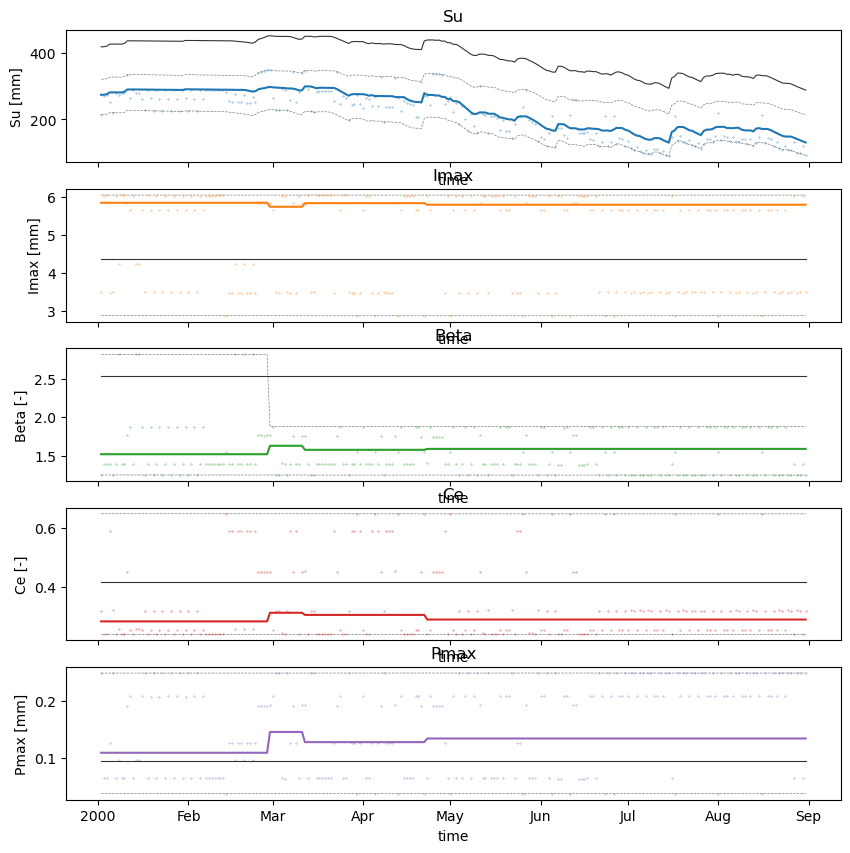

In [57]:
names = ['Su','Imax','Beta','Ce','Pmax']
n = len(names)
fig, ax = plt.subplots(n,1, figsize=(10,n*2),sharex=True)
ax = ax.flatten()

plot_params(names, ds_lst, ax)


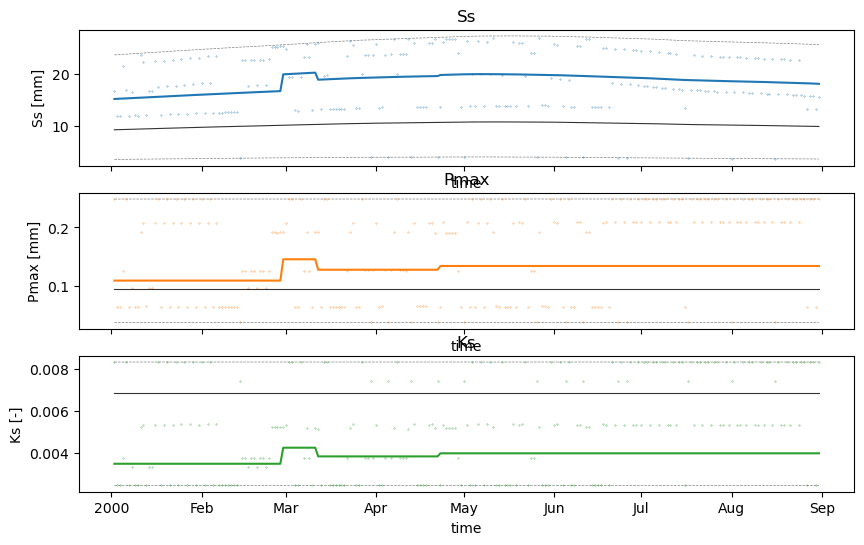

In [58]:
names = ['Ss','Pmax','Ks']
n = len(names)
fig, ax = plt.subplots(n,1, figsize=(10,n*2),sharex=True)
ax = ax.flatten()

plot_params(names, ds_lst, ax)


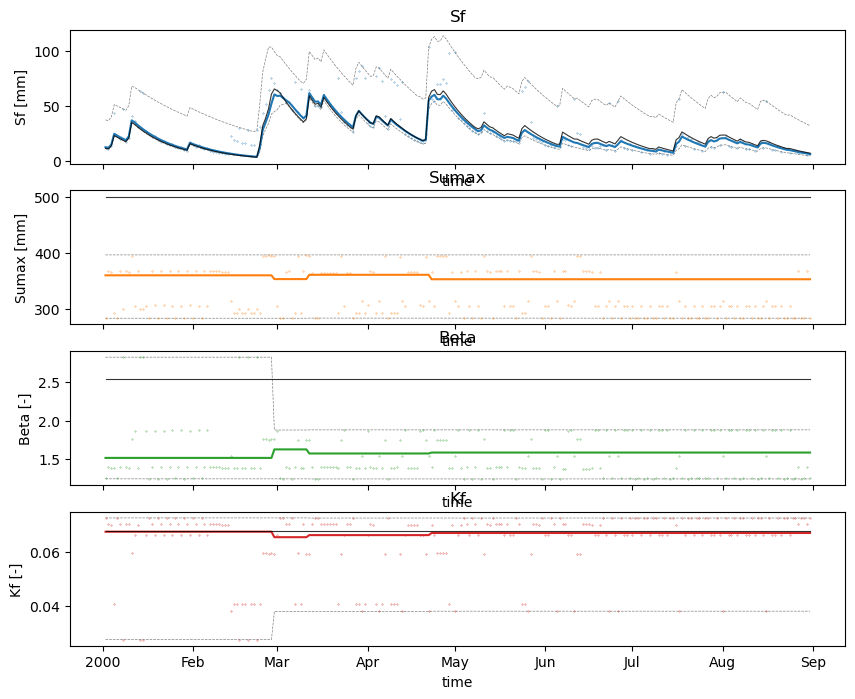

In [59]:
names = ['Sf','Sumax','Beta','Kf']
n = len(names)
fig, ax = plt.subplots(n,1, figsize=(10,n*2),sharex=True)
ax = ax.flatten()

plot_params(names, ds_lst, ax)


### investigate missed flood peak

In [60]:
fig, ds_lst= generate_plots(df, '01073000')
fig2, ds_lst = plot_residuals(ds_lst,diff=True)
plt.close(fig)
plt.close(fig2)

ds0, ds1 = ds_lst
t_index = (ds0.time > np.datetime64('1998-04-01')) & (ds0.time < np.datetime64('1998-10-01')).values
ds_lst = [ds0.sel(time=t_index), ds1.sel(time=t_index)]

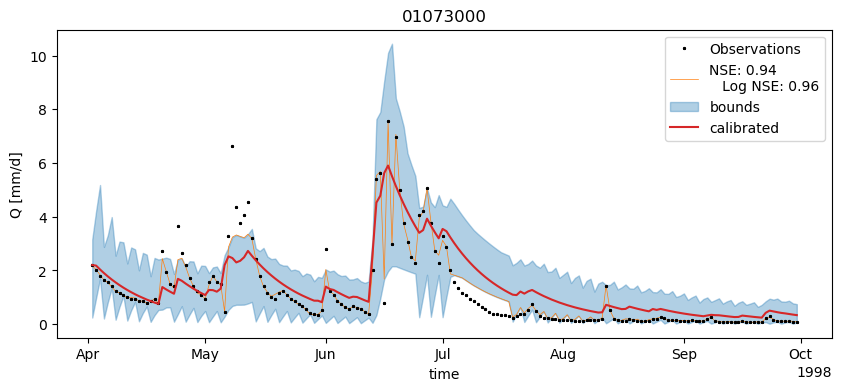

In [61]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
plot_hydrograph(ds_lst[0], ax, summary_stat='best')
ds_lst[1]['Q'].plot(ax=ax,color='C3',label='calibrated')
ax.legend()
ax.set_title(f'{ds_lst[0].attrs["HRU_id"]}');

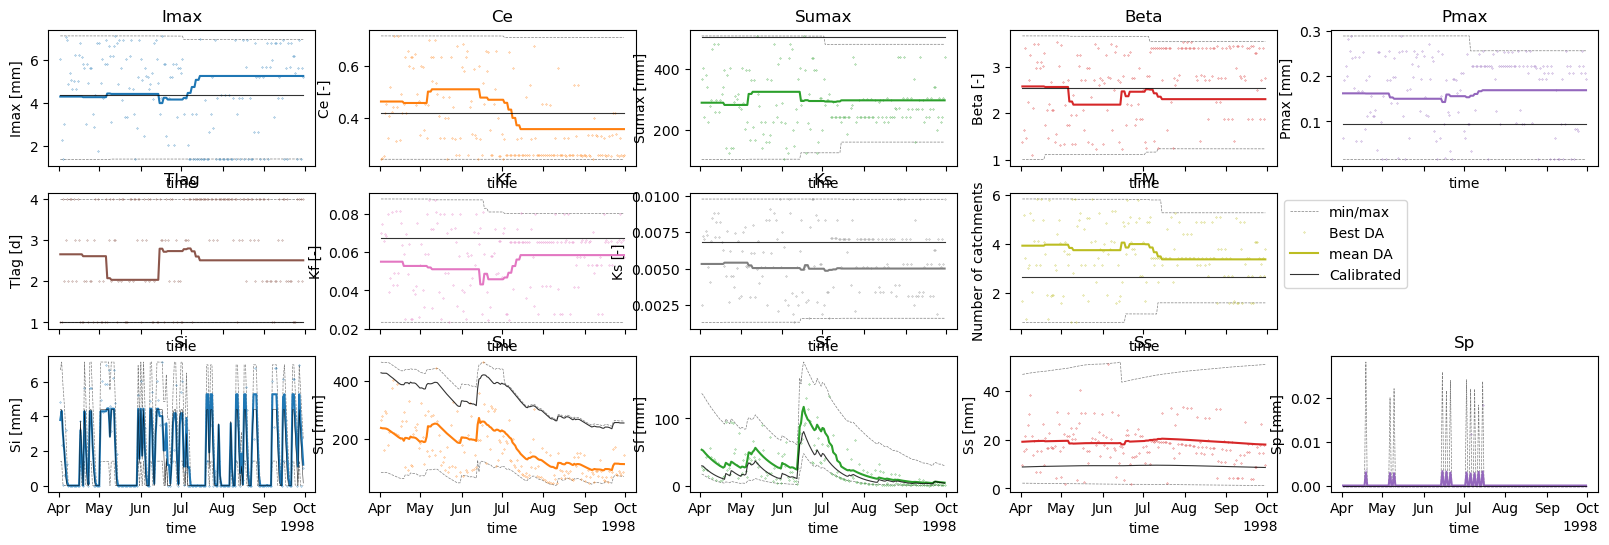

In [62]:
fig, ax = plt.subplots(3,5, figsize=(20,6),sharex=True)
ax = ax.flatten()
names = param_names + [None] + stor_names
plot_params(names, ds_lst, ax)

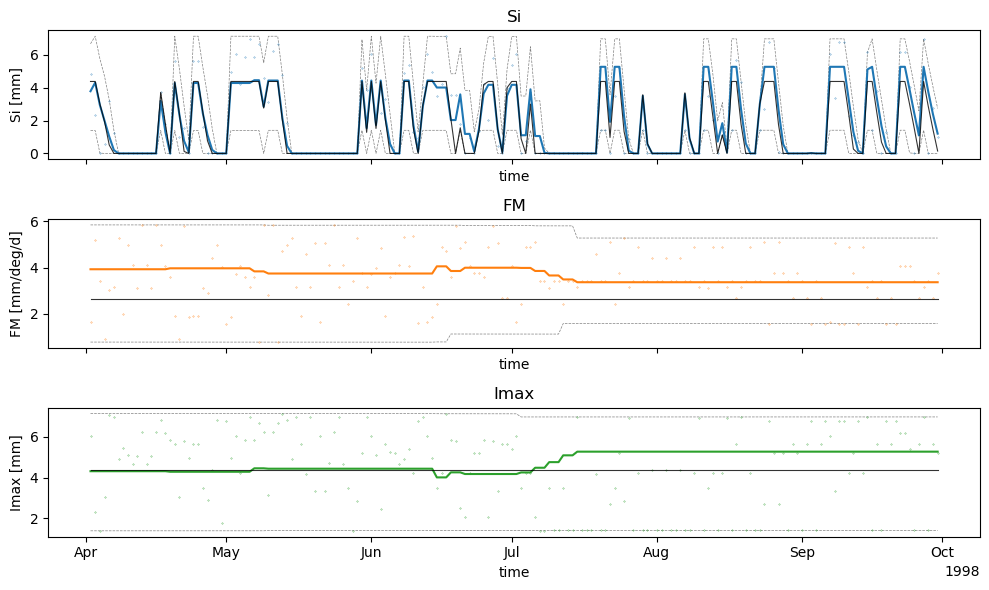

In [63]:
names = ['Si','FM','Imax']
n = len(names)
fig, ax = plt.subplots(n,1, figsize=(10,n*2),sharex=True)
ax = ax.flatten()
plot_params(names, ds_lst, ax)
fig.tight_layout()

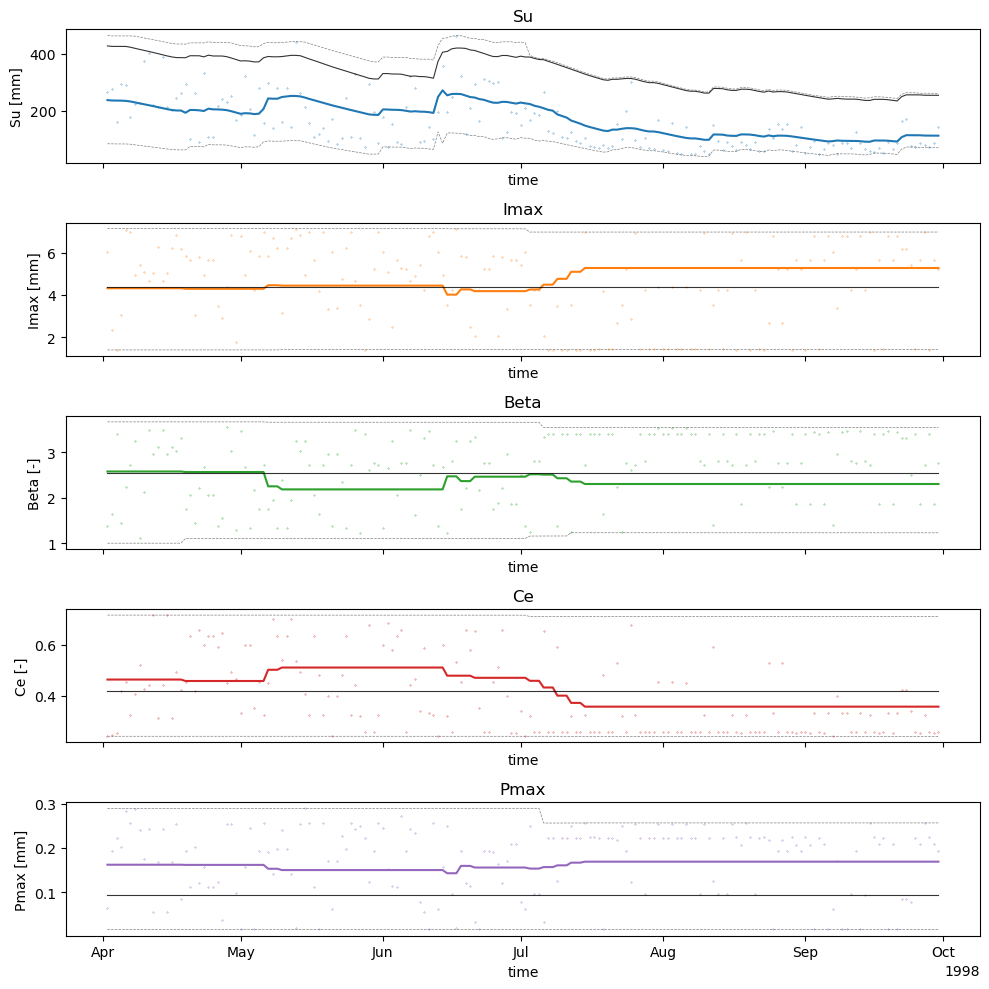

In [64]:
names = ['Su','Imax','Beta','Ce','Pmax']
n = len(names)
fig, ax = plt.subplots(n,1, figsize=(10,n*2),sharex=True)
ax = ax.flatten()

plot_params(names, ds_lst, ax)
fig.tight_layout()

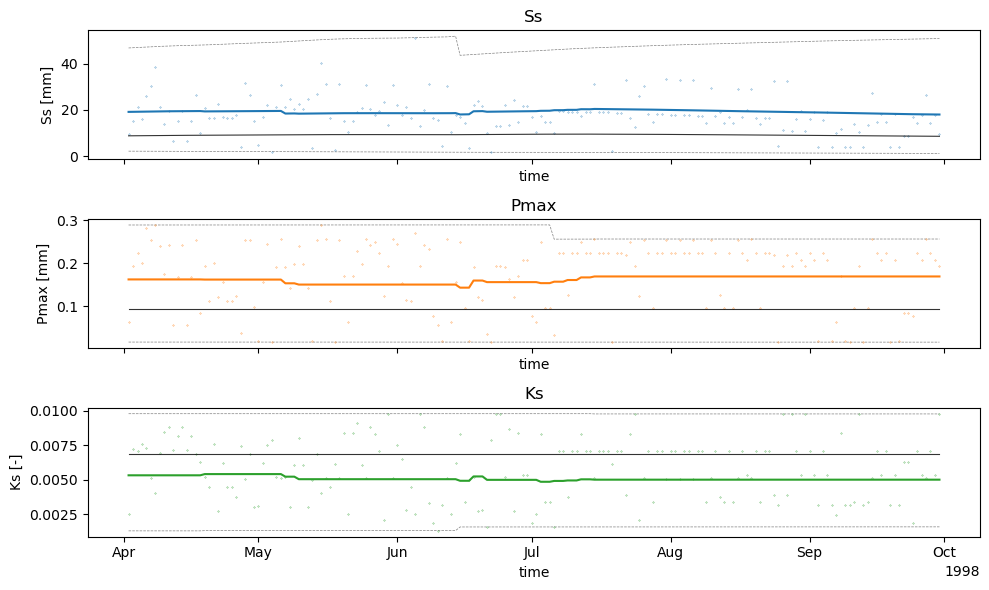

In [65]:
names = ['Ss','Pmax','Ks']
n = len(names)
fig, ax = plt.subplots(n,1, figsize=(10,n*2),sharex=True)
ax = ax.flatten()

plot_params(names, ds_lst, ax)
fig.tight_layout()

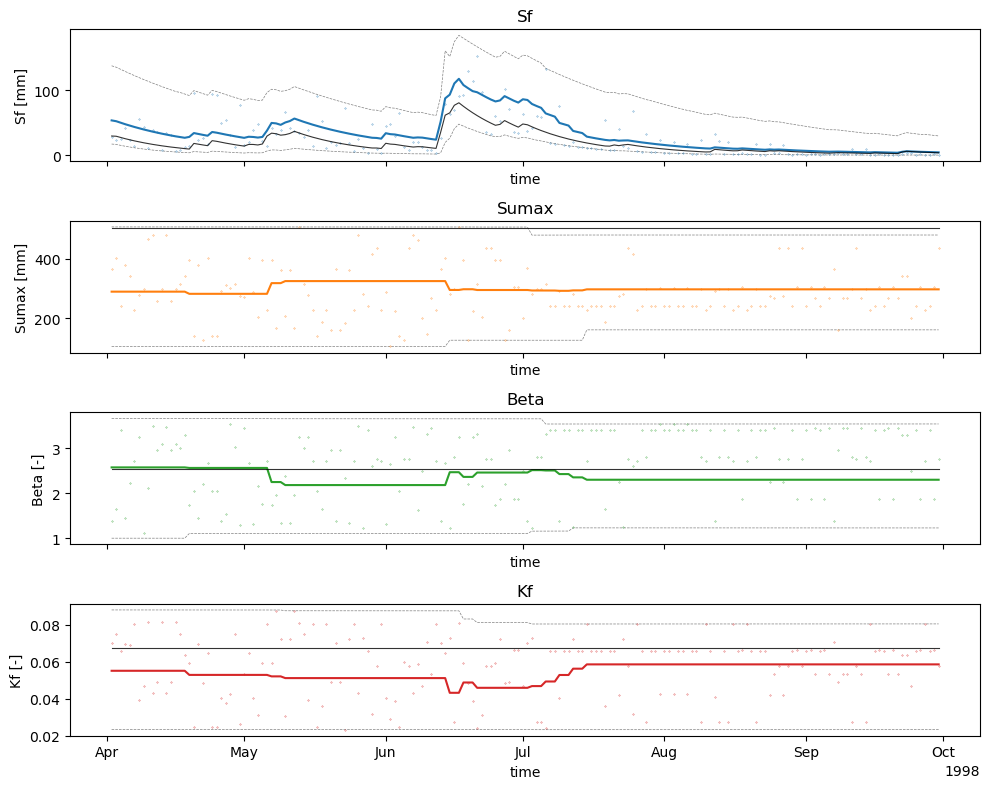

In [66]:
names = ['Sf','Sumax','Beta','Kf']
n = len(names)
fig, ax = plt.subplots(n,1, figsize=(10,n*2),sharex=True)
ax = ax.flatten()

plot_params(names, ds_lst, ax)
fig.tight_layout()

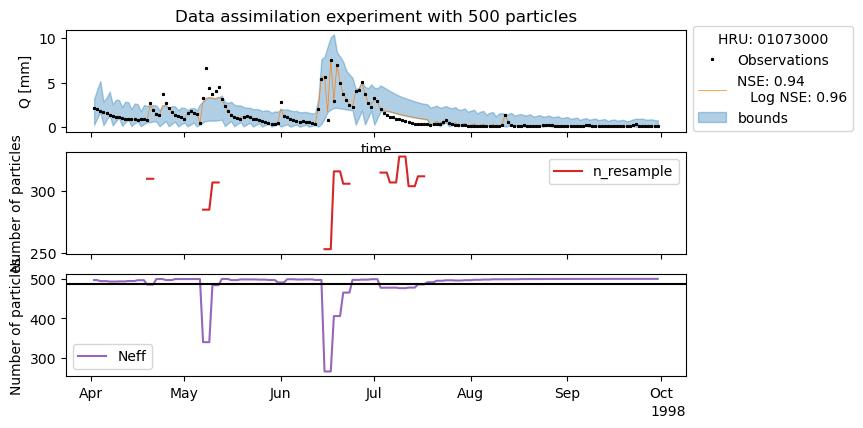

In [67]:
fig, ax = plt.subplots(3,1, figsize=(8,4.5),sharex=True)
ax[0] = plot_hydrograph(ds_lst[0], ax[0], 'best')
ax[0].legend(title=f"HRU: {ds_lst[0].attrs['HRU_id']}",bbox_to_anchor=(1.,1.1))
for j, val in enumerate(['n_resample','Neff']):
    ax[j+1].plot(ds_lst[0]['time'].values, ds_lst[0][val].values,color=f"C{j+3}",label=val)
    ax[j+1].legend()
    ax[j+1].set_ylabel('Number of particles')
ax[2].axhline(ds_lst[0].attrs['n_particles']*0.975, color='k');

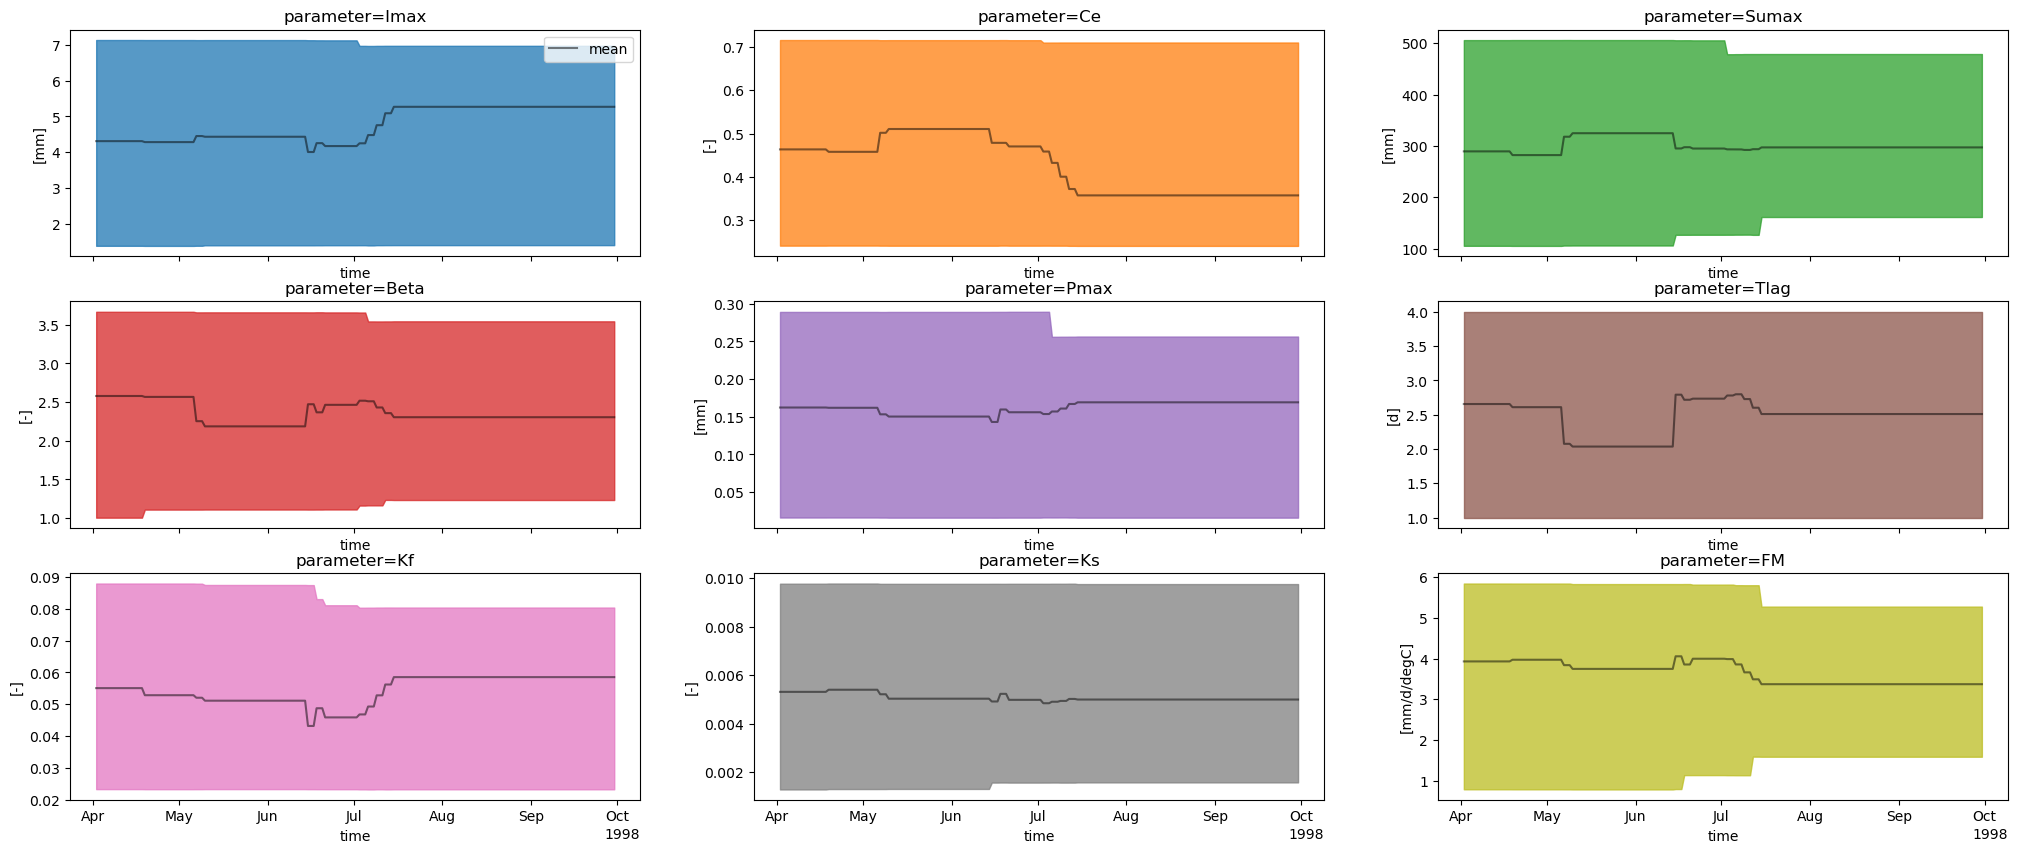

In [68]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
plot_params_slope(ds_lst[0], param_names,axs, regress=False)

In [69]:
# fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
# axs = axs.flatten()
# plot_params(param_names, ds_lst, axs)
# fig.tight_layout()

# Using mean:

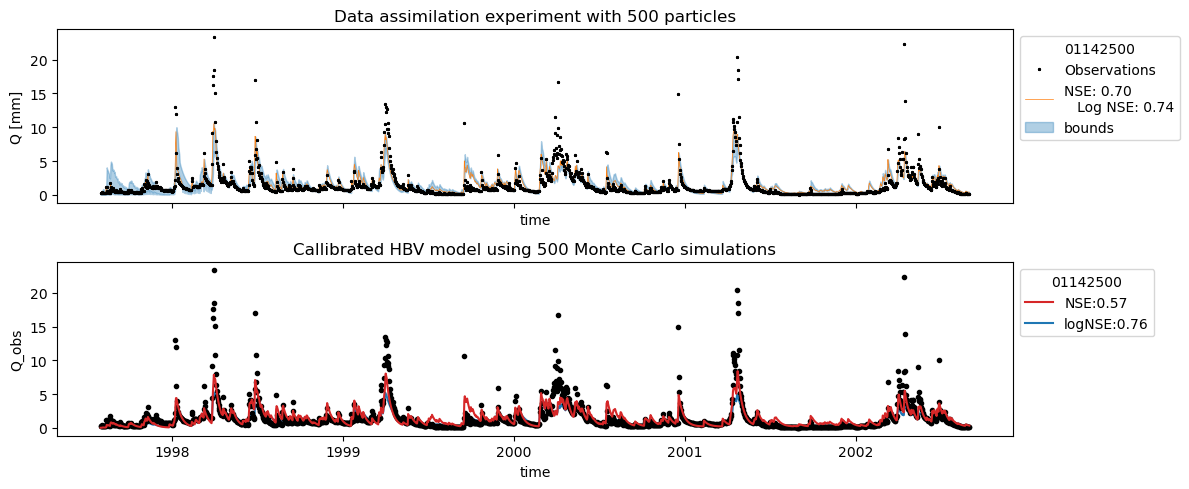

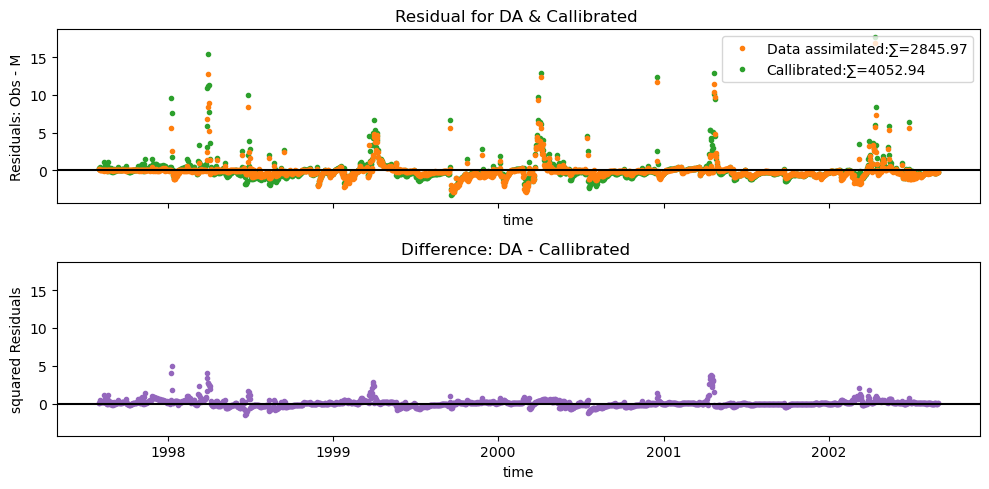

In [70]:
fig, ds_lst= generate_plots(df, '01142500')
# fig.savefig(figure_path / f"Ensemble run vs callibrated value for {ds.attrs['HRU_id']}.png",bbox_inches="tight", dpi=150)
fig2 = plot_residuals(ds_lst, diff=True)


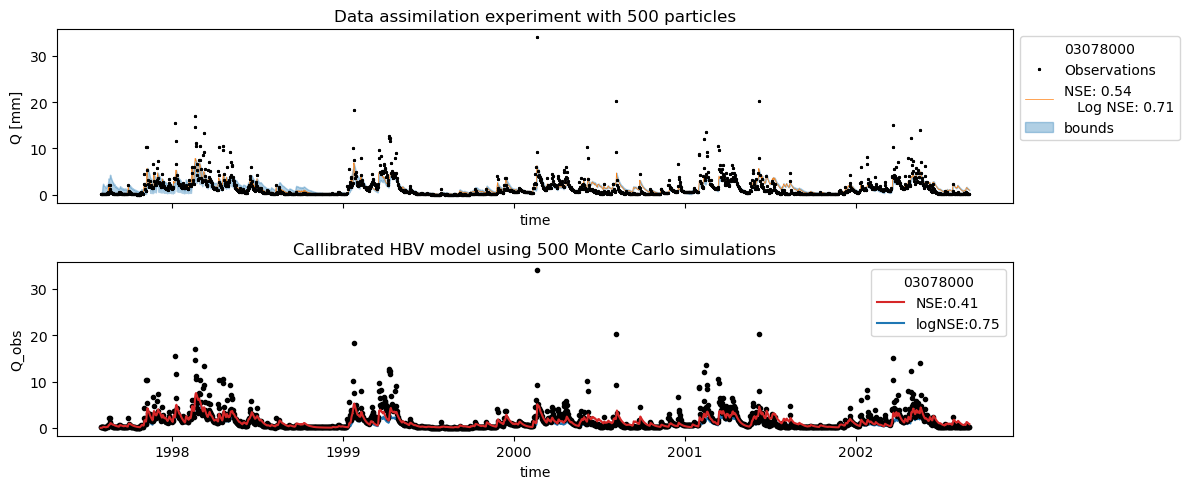

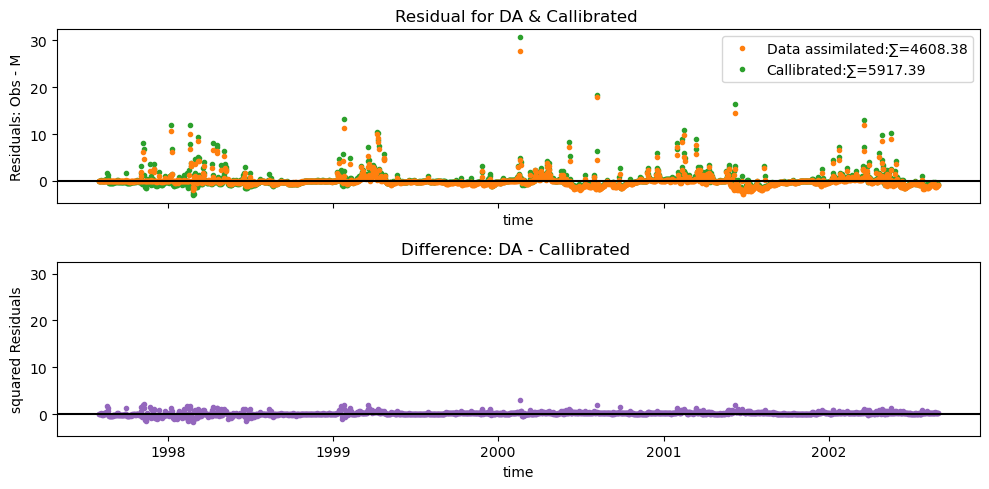

In [71]:
fig, ds_lst= generate_plots(df, '03078000')
# fig.savefig(figure_path / f"Ensemble run vs callibrated value for {ds.attrs['HRU_id']}.png",bbox_inches="tight", dpi=150)
fig2 = plot_residuals(ds_lst, diff=True)


# Noise/errors in data? 

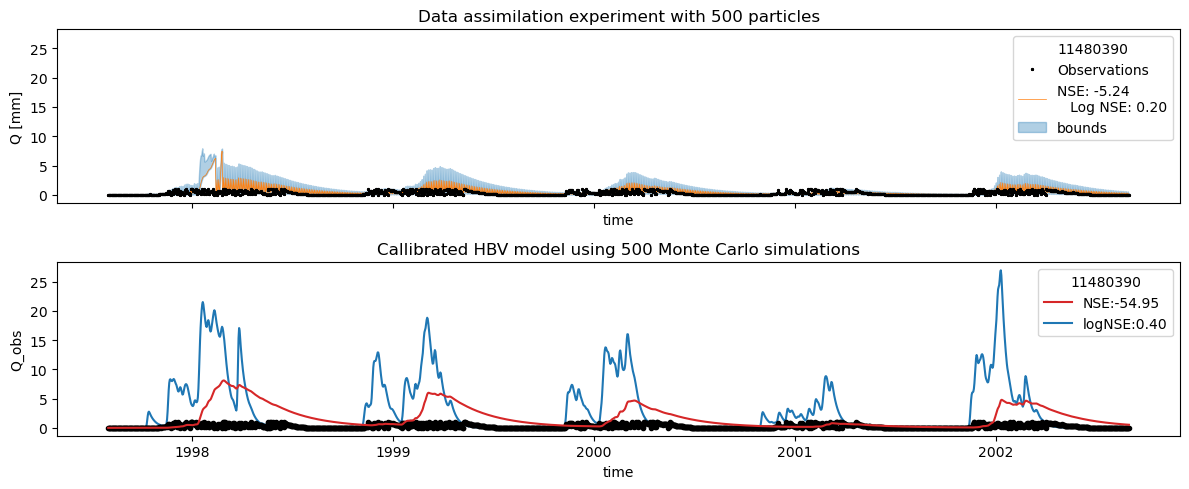

In [72]:
fig, ds_lst= generate_plots(df, '11480390')


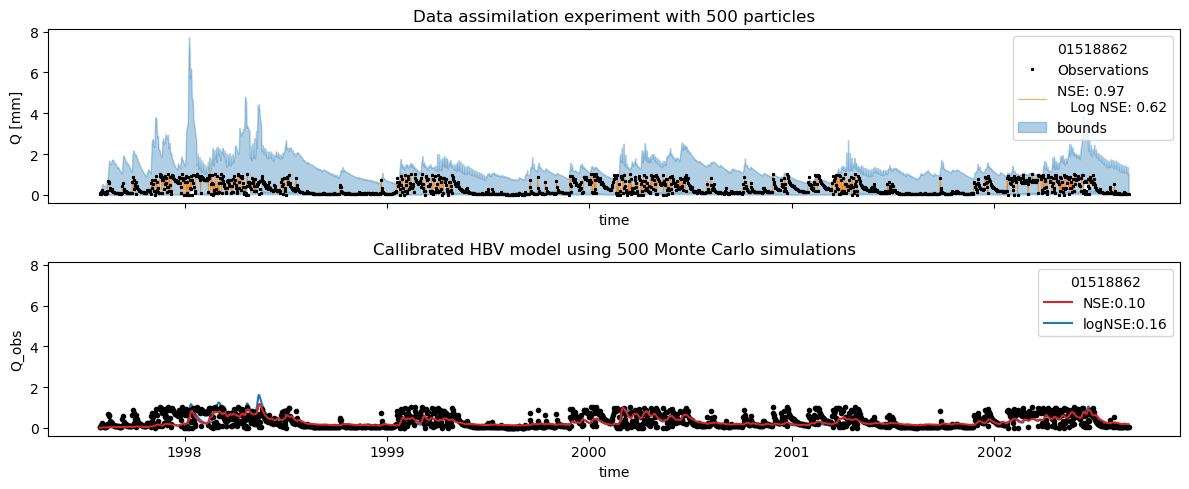

In [73]:
fig, ds_lst= generate_plots(df, '01518862')
# fig.savefig(figure_path / f"Ensemble run vs callibrated value for {ds.attrs['HRU_id']}.png",bbox_inches="tight", dpi=150)